# What features contributed to particular predictions


lets see which features contributed to particular predictions

See <a href="https://blog.datadive.net/interpreting-random-forests/">Tree Interpreter for Random Forest</a> for general setup, and <a href="https://blog.datadive.net/random-forest-interpretation-with-scikit-learn/">Random forest interpretation with scikit-learn</a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

## Install
This is a great library, BUT conda currently has version 2.1 which is incompatible with sklearn, pip has version 2.2 which works.<br>
<mark>This is an example of a package that may no longer be maintained, so don't set your hopes on long term usage.

In [2]:
# !pip install treeinterpreter

# Data

In [3]:
from sklearn.datasets import fetch_california_housing

calif_housing = fetch_california_housing()

for line in calif_housing.DESCR.split("\n")[5:22]:
    print(line)

calif_housing_df = pd.DataFrame(data=calif_housing.data, columns=calif_housing.feature_names)
calif_housing_df["Price($)"] = calif_housing.target

calif_housing_df.head()

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price($)
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [17]:
#get train/test split
from sklearn.model_selection import train_test_split
X, y = calif_housing.data, calif_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,test_size=0.2,random_state=123)

# Model- Regression (treeinterpreter also works with classification)

In [89]:
%%time
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=3)
clf.fit(X_train, y_train)
print("Accuracy (F^2) on test set: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy (F^2) on test set: 0.55
CPU times: user 480 ms, sys: 0 ns, total: 480 ms
Wall time: 478 ms


# treeinterpreter
random forests can be turned into a “white box”, such that each prediction is decomposed into a sum of contributions from each feature according to the following formula<br>
![](./ti.png)

The tree has conditions on each internal node and a value associated with each leaf (i.e. the value to be predicted). Additionally the value at each internal node i.e. the mean of the response variables in that region is also shown.  WIth this we can calculate what is gained (or lost) for the prediction at each node.

![](./tree_ex.png)

The treeinterpreter has a single method named predict() which takes as input model instance and dataset for which we need explanations

## Use a subset of the test data or the following cell will take a while

In [102]:
X_test=X_test[:1000]
y_test=y_test[:1000]

In [91]:
%%time
from treeinterpreter import treeinterpreter as ti
#decompose the predictions into:
# preds: ti preds per row in X_test
# bias: the preds dataset target (y_test) mean 
# contributions: feature contributions per row, shows amount each features contributed 
# to the difference and by how much.
preds, bias, contributions = ti.predict(clf, X_test)
preds.shape, bias.shape, contributions.shape

CPU times: user 11.1 ms, sys: 0 ns, total: 11.1 ms
Wall time: 10.5 ms


((300, 1), (300,), (300, 8))

In [92]:
#the bias term
print(f'preds.mean()={y_train.mean():.2f}')
print(f'bias={bias[0]:.2f}')

preds.mean()=2.07
bias=2.07


In [93]:
print(f"Bias for preds (same for all preds entries) {bias[0]:.2f}")
print(f"Contributions For Sample 0              :{contributions[0]}")
print(f"Prediction Based on Bias & Contributions {bias[0] + contributions[0].sum():.2f}")
print(f"Actual Target Value                      :{y_test[0]:.2f}")
print(f"Target Value As Per Treeinterpreter      :{preds[0][0]:.2f}")

Bias for preds (same for all preds entries) 2.07
Contributions For Sample 0              :[ 0.04900653  0.          0.          0.          0.         -0.22065921
  0.          0.        ]
Prediction Based on Bias & Contributions 1.90
Actual Target Value                      :1.52
Target Value As Per Treeinterpreter      :1.90


In [94]:
import random

random_sample = random.randint(1, len(X_test))
print("Selected Sample     : %d"%random_sample)
print("Actual Target Value : %.2f"%y_test[random_sample])
print("Predicted Value     : %.2f"%preds[random_sample][0])

def create_contrbutions_df(contributions, random_sample, feature_names):
    #generate a dataframe with features for this row as well as how much each 
    #feature contributed to target value
    contribs = contributions[random_sample].tolist()
    contribs.insert(0, bias[random_sample])
    contribs = np.array(contribs)
    contrib_df = pd.DataFrame(data=contribs, index=["Base"] + feature_names, columns=["Contributions"])
    prediction = contrib_df.Contributions.sum()
    contrib_df.loc["Prediction"] = prediction
    return contrib_df

contrib_df = create_contrbutions_df(contributions, random_sample, calif_housing.feature_names)
contrib_df

Selected Sample     : 244
Actual Target Value : 0.88
Predicted Value     : 1.26


,Contributions
Base,2.068698
MedInc,-0.700767
HouseAge,0.000000
AveRooms,-0.151366
AveBedrms,0.000000
Population,0.000000
AveOccup,0.000000
Latitude,0.048003
Longitude,0.000000
Prediction,1.264567


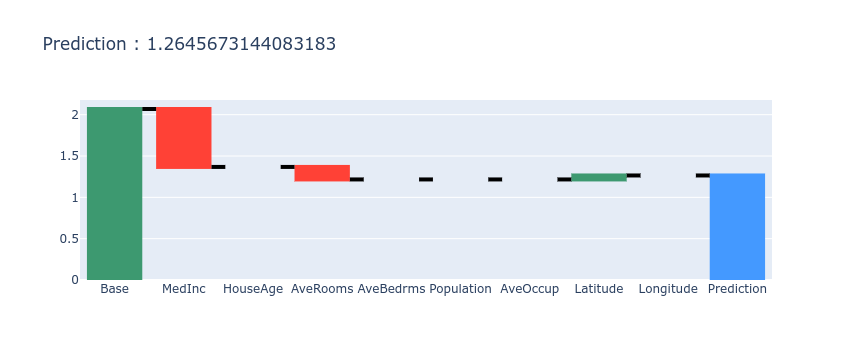

In [95]:
import plotly.graph_objects as go

def create_waterfall_chart(contrib_df, prediction):
    #graphically show what each feature contributed to final prediction for this row
    fig = go.Figure(go.Waterfall(
        name = "Prediction", #orientation = "h", 
        measure = ["relative"] * (len(contrib_df)-1) + ["total"],
        x = contrib_df.index,
        y = contrib_df.Contributions,
        connector = {"mode":"between", "line":{"width":4, "color":"rgb(0, 0, 0)", "dash":"solid"}}
    ))

    fig.update_layout(title = "Prediction : %s"%prediction)

    return fig

create_waterfall_chart(contrib_df, contrib_df.loc["Prediction"][0])

## We can also use tree interpreter to determine why 2 datasets are different

In [96]:
#lets take the first and last hunder rows from the dataset
ds1=X_test[:100]
ds2=X_test[100:]

In [97]:
#notice I get different price predictions
print(f'{np.mean(clf.predict(ds1))}')
print(f'{np.mean(clf.predict(ds2))}')

2.0390455005046566
2.024475785512251


We can see that the average predicted prices for the houses in the two datasets are quite different. We can now trivially break down the contributors to this difference: which features contribute to this different and by how much.

In [98]:
prediction1, bias1, contributions1 = ti.predict(clf, ds1)
prediction2, bias2, contributions2 = ti.predict(clf, ds2)

In [99]:
# We can now calculate the mean contribution of each feature to the difference.
totalc1 = np.mean(contributions1, axis=0) 
totalc2 = np.mean(contributions2, axis=0) 

Since biases are equal for both datasets (because the training data for the model was the same), the difference between the average predicted values has to come only from feature contributions. In other words, the sum of the feature contribution differences should be equal to the difference in average prediction, which we can trivially check to be the case

In [100]:
print(f'{np.sum(totalc1 - totalc2)}')
print(f'{np.mean(prediction1) - np.mean(prediction2)}')


0.01456971499240509
0.014569714992405558


<mark>Finaly, we can see what made these 2 datasets different

In [101]:
for c, feature in sorted(zip(totalc1 - totalc2, calif_housing.feature_names), reverse=True):
    print(feature, round(c, 2))

MedInc 0.02
Latitude 0.01
HouseAge 0.0
Population 0.0
Longitude 0.0
AveBedrms 0.0
AveOccup -0.01
AveRooms -0.01


For the above 2 slices of the dataset, the positive features added th most to the price, the negative ones subtracted from it.